# Set model to visualize
After setting these values, just run all cells. 

In [ ]:
# Model filename
# model-max/min/avg/middle-window-batch-learningrate-momentum-wd-epoch.params
model_fn = 'ResNet50_v2-middle-window2-batch16-lr0.001-mom0.9-wd0.0001-epoch39.params'

### Set batch size and number of GPUs
 

In [ ]:
per_device_batch_size = 16
num_gpus = 1
num_workers = 8
batch_size = per_device_batch_size * max(num_gpus, 1)

# Setup



### Install MXNet and GluonCV

In [ ]:
!pip install --upgrade mxnet-cu101 gluoncv

     |███████████████████████████████▌| 834.1MB 1.2MB/s eta 0:00:10tcmalloc: large alloc 1147494400 bytes == 0x39a32000 @  0x7fb304dee615 0x591e47 0x4cc179 0x4cc2db 0x50a1cc 0x50beb4 0x507be4 0x509900 0x50a2fd 0x50beb4 0x507be4 0x509900 0x50a2fd 0x50cc96 0x58e683 0x50c127 0x58e683 0x50c127 0x58e683 0x50c127 0x58e683 0x50c127 0x5095c8 0x50a2fd 0x50beb4 0x507be4 0x509900 0x50a2fd 0x50beb4 0x5095c8 0x50a2fd
     |████████████████████████████████| 846.0MB 22kB/s 
     |████████████████████████████████| 819kB 44.9MB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


### Import necessary packages

In [ ]:
import mxnet as mx
import numpy as np
import os, time, shutil

from mxnet import gluon, image, init, nd, npx, ndarray
from mxnet import autograd as ag
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms
from gluoncv.utils import makedirs, TrainingHistory
from gluoncv.model_zoo import get_model

import matplotlib.pyplot as plt
import os
from google.colab import files, drive   
import pandas as pd

### Extract info from model filename

In [ ]:
model_params = model_fn[:-7].split('-')
[model_name, agg_fn, window0] = model_params[:3]
window = window0[len('window'):]

# Data

### Mount Google Drive

In [ ]:
drive.mount('/content/gdrive')
print(os.listdir('/content/gdrive/My Drive/'))

Mounted at /content/gdrive
['cs101', 'Getting started.pdf', 'Colab Notebooks', 'embryo_13_fluo_sequence.mp4', 'embryo_13_fluo_slice.mp4', 'embryo_13_bf_slice.mp4', 'embryo_13_bf_sequence.mp4', 'hi', 'embryo data.gsheet', 'classify_fluo_pretrained.ipynb', 'classify_fluo_CNN_2.ipynb', 'Copy of Pyramid Principle Exercise.gslides']


### Define filepaths

In [ ]:
home_path = '/content/gdrive/My Drive/cs101'

# Directories for input data
data_path = os.path.join(home_path, 'processed', 'fluo_data', agg_fn)
train_path = os.path.join(data_path, f'train_{window}')
val_path = os.path.join(data_path, f'val_{window}')
test_path = os.path.join(data_path, f'test_{window}')

### Data augmentation

In [ ]:
transform_train = transforms.Compose([
    transforms.Resize(600, keep_ratio=True),
    transforms.CenterCrop(512),

    transforms.RandomFlipLeftRight(), # Randomly flip the image horizontally
    transforms.RandomFlipTopBottom(),
    transforms.RandomLighting(0.1), # Add AlexNet-style PCA-based noise to an image
    transforms.RandomContrast(0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize(600, keep_ratio=True),
    transforms.CenterCrop(512),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


### Define data loader

In [ ]:
train_data = gluon.data.DataLoader(
    gluon.data.vision.ImageFolderDataset(train_path).transform_first(transform_train),
    batch_size=batch_size, shuffle=True, num_workers=num_workers)

val_data = gluon.data.DataLoader(
    gluon.data.vision.ImageFolderDataset(val_path).transform_first(transform_train),
    batch_size=batch_size, shuffle=True, num_workers = num_workers)

test_data = gluon.data.DataLoader(
    gluon.data.vision.ImageFolderDataset(test_path).transform_first(transform_test),
    batch_size=batch_size, shuffle=False, num_workers = num_workers)

# Model


In [ ]:
classes = 2
ctx = [mx.gpu(i) for i in range(num_gpus)] if num_gpus > 0 else [mx.cpu()]
print(ctx)
# Fine-tuning pre-trained models: train model on my new data using the pre-trained weights as initialization -- transfer learning
finetune_net = get_model(model_name, pretrained=True)
with finetune_net.name_scope():
    finetune_net.output = nn.Dense(classes)

finetune_net.output.initialize(init.Xavier(), ctx = ctx)
finetune_net.collect_params().reset_ctx(ctx)
finetune_net.hybridize()

model_fp = os.path.join(home_path, 'models', 'best', model_fn)
finetune_net.load_parameters(model_fp, ctx=ctx)

[gpu(0)]


92863KB [00:01, 63992.76KB/s]                           


### Calculate test accuracy

In [ ]:
# define an evaluation function for validation and testing
def test(net, test_data, ctx):
    metric = mx.metric.Accuracy()
    for i, batch in enumerate(test_data):
        data = gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0, even_split=False)
        label = gluon.utils.split_and_load(batch[1], ctx_list=ctx, batch_axis=0, even_split=False)
        outputs = [net(X) for X in data]
        metric.update(label, outputs)

    return metric.get()

# run on test data
_, test_acc = test(finetune_net, test_data, ctx)
print('[Finished] Test-acc: %.3f' % (test_acc))

[Finished] Test-acc: 0.948


# Visualize

### Summarize test prediction results

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


Text(0, 0.5, 'Label')

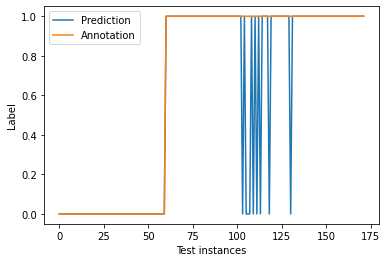

In [ ]:
# summarize test prediction results
record_pred = []
record_label = []
for i, batch in enumerate(test_data):
  data = gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0, even_split=False)
  label = gluon.utils.split_and_load(batch[1], ctx_list=ctx, batch_axis=0, even_split=False)
  outputs = [finetune_net(X) for X in data]
  a = np.argmax(outputs[0].asnumpy(),axis=1).astype('int32')
  b = label[0].asnumpy()
  if record_pred == []:
    record_pred = a
    record_label = b
  else:
    record_pred = np.concatenate((record_pred, a), axis=0)
    record_label = np.concatenate((record_label, b), axis=0)

plt.figure()
plt.plot(np.arange(len(record_pred)),record_pred,label='Prediction')
plt.plot(np.arange(len(record_label)),record_label,label='Annotation')
plt.legend()
plt.xlabel('Test instances')
plt.ylabel('Label')

### Confusion matrix

[[ 60   0]
 [  9 103]]


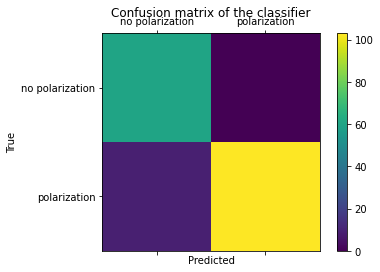

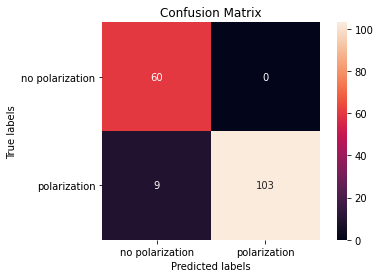

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

labels = ['no polarization','polarization']
cm = confusion_matrix(record_label, record_pred)
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt="d", ax=ax) # annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['no polarization', 'polarization'])
ax.yaxis.set_ticklabels(['no polarization', 'polarization'], rotation='horizontal')
ax.set_aspect('equal', 'box')

### Attention of CNN

This section refers to https://discuss.mxnet.io/t/how-to-visualize-image-classification-resnetv2/4969

Another similar realization can be seen in https://github.com/nicklhy/CAM/blob/master/cam.ipynb

About Class Activation Maps(CAM):
https://towardsdatascience.com/demystifying-convolutional-neural-networks-using-class-activation-maps-fe94eda4cef1

In [ ]:
import cv2
from mpl_toolkits.axes_grid1 import make_axes_locatable

def returnCAM(feature_conv, weight_softmax, idx):
    # generate the class activation maps upsample to 256x256
    size_upsample = (256, 256)
    bz, nc, h, w = feature_conv.shape
    # cam = weight_softmax[idx].dot(feature_conv.reshape((nc, h*w)))
    cam = weight_softmax[idx].dot(feature_conv.reshape((nc, h*w)))
    cam = cam.reshape(h, w)
    cam = cam - np.min(cam)
    cam_img = cam / np.max(cam)
    cam_img = np.uint8(255 * cam_img)
    return cv2.resize(cam_img, size_upsample)

def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def collapse_same_frame(images):
  delete_idx = []
  for i in range(images.shape[-1]):
    img1 = images[:,:,i]
    for j in range(i+1,images.shape[-1]):
      img2 = images[:,:,j]
      if np.array_equal(img1,img2):
        delete_idx.append(j) 
  images_return = np.delete(images,np.unique(np.asarray(delete_idx)),-1)
  return images_return 

# define a helper to display multiple images in a row in notebook
def show_images(images, titles, cmaps):
    num_images = len(images)
    rows, cols = 1, num_images

    fig, axs = plt.subplots(rows, cols, figsize=(15, 15))
    for i in range(num_images):
        img = images[i].astype(np.uint8)
        axs[i].set_title(titles[i])

        if len(img.shape)==2:
          im = axs[i].imshow(img, cmap=cmaps[i])
          # create an axes on the right side of ax. The width of cax will be 5%
          # of ax and the padding between cax and ax will be fixed at 0.05 inch.
          divider = make_axes_locatable(axs[i])
          cax = divider.append_axes("right", size="5%", pad=0.05)
          plt.colorbar(im, cax=cax)
        else:
          im = axs[i].imshow(img, cmap=None)
    return fig

#### Correct prediction

In [ ]:
group_id = 3 #3
for i, batch in enumerate(test_data):
    data = gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0, even_split=False)
    label = gluon.utils.split_and_load(batch[1], ctx_list=ctx, batch_axis=0, even_split=False)
    if i == group_id:
      break

In [ ]:
# get an image
test_idx = 15 #15
test_image = data[0][test_idx].expand_dims(0)
test_label = label[0][test_idx].asnumpy()
print(test_image.shape, type(test_image))

(1, 3, 512, 512) <class 'mxnet.ndarray.ndarray.NDArray'>


Annotated label: polarization
Network prediction: polarization
<class 'numpy.ndarray'> (512, 512, 3)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


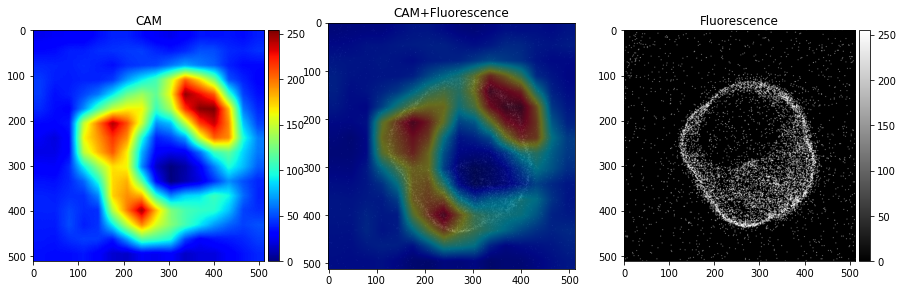

In [ ]:
output = finetune_net(test_image)
classes = ['no polarization','polarization']
idx = mx.nd.argmax(output).asscalar().astype('int32')

params_list = list(finetune_net.collect_params())
weight_softmax = finetune_net.collect_params()[params_list[-2]].data().asnumpy()
features_blob = finetune_net.features[:-4](test_image).asnumpy()

CAMs = returnCAM(features_blob, weight_softmax, idx)
_ , _ , height, width = test_image.shape
test_CAM = np.swapaxes(cv2.resize(CAMs,(width, height)), 0, 1)
# test_CAM = cv2.resize(CAMs,(width, height))
print('Annotated label: %s'%classes[int(test_label)])
print('Network prediction: %s'%classes[idx])

# convert <NDArray 1x3x512x512 @gpu(0)> to <NumArray 512x512x3 @memory>
test_image_narray = np.swapaxes(np.squeeze(test_image.asnumpy()),0,2)
test_image_narray = (NormalizeData(test_image_narray)*255).astype(np.uint8)

test_image_squeeze = np.squeeze(collapse_same_frame(test_image_narray))

heatmap = cv2.applyColorMap(255-test_CAM, cv2.COLORMAP_JET)
print(type(heatmap), heatmap.shape)
overlay = heatmap * 0.4 + test_image_narray * 0.6

images = []
images.append(test_CAM)
images.append(overlay.astype('uint8'))
images.append(cv2.equalizeHist(cv2.cvtColor(test_image_squeeze,cv2.COLOR_BGR2GRAY)))

titles = ['CAM','CAM+Fluorescence','Fluorescence']
cmaps = ['jet',None,'gray']
fig = show_images(images, titles, cmaps)

#### Mistaken prediction

In [ ]:
tp = record_pred==record_label
itemindex = np.where(tp==False)
print(itemindex)

(array([103, 105, 106, 107, 109, 111, 113, 118, 130]),)


Annotated label: polarization
Network prediction: no polarization
<class 'numpy.ndarray'> (512, 512, 3)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


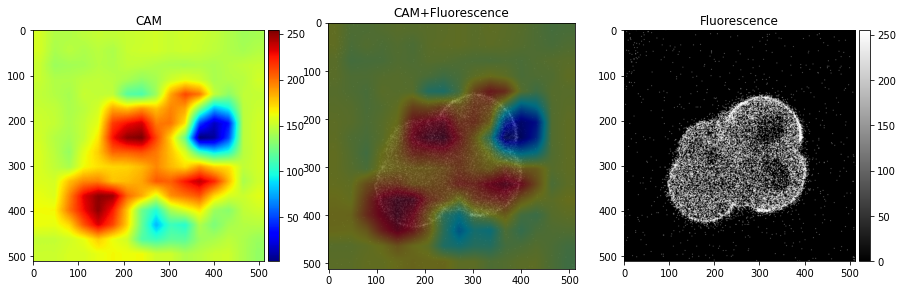

In [ ]:
FN_idx = -2
group_id = np.floor(itemindex[-1][FN_idx]/batch_size)
for i, batch in enumerate(test_data):
    data = gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0, even_split=False)
    label = gluon.utils.split_and_load(batch[1], ctx_list=ctx, batch_axis=0, even_split=False)
    if i == group_id:
      break
test_idx = np.remainder(itemindex[0][FN_idx], batch_size)
test_image = data[0][test_idx].expand_dims(0)
test_label = label[0][test_idx].asnumpy()

output = finetune_net(test_image)
classes = ['no polarization','polarization']
idx = mx.nd.argmax(output).asscalar().astype('int32')

params_list = list(finetune_net.collect_params())
weight_softmax = finetune_net.collect_params()[params_list[-2]].data().asnumpy()
features_blob = finetune_net.features[:-4](test_image).asnumpy()

CAMs = returnCAM(features_blob, weight_softmax, idx)
_ , _ , height, width = test_image.shape
test_CAM = np.swapaxes(cv2.resize(CAMs,(width, height)), 0, 1)
# test_CAM = cv2.resize(CAMs,(width, height))
print('Annotated label: %s'%classes[int(test_label)])
print('Network prediction: %s'%classes[idx])

# convert <NDArray 1x3x512x512 @gpu(0)> to <NumArray 512x512x3 @memory>
test_image_narray = np.swapaxes(np.squeeze(test_image.asnumpy()),0,2)
test_image_narray = (NormalizeData(test_image_narray)*255).astype(np.uint8)

test_image_squeeze = np.squeeze(collapse_same_frame(test_image_narray))

heatmap = cv2.applyColorMap(255-test_CAM, cv2.COLORMAP_JET)
print(type(heatmap), heatmap.shape)
overlay = heatmap * 0.4 + test_image_narray * 0.6

images = []
images.append(test_CAM)
images.append(overlay.astype('uint8'))
images.append(cv2.equalizeHist(cv2.cvtColor(test_image_squeeze,cv2.COLOR_BGR2GRAY)))

titles = ['CAM','CAM+Fluorescence','Fluorescence']
cmaps = ['jet',None,'gray']
fig = show_images(images, titles, cmaps)